In [1]:
from msmbuilder.example_datasets import AlanineDipeptide
from msmbuilder.preprocessing import MinMaxScaler
%matplotlib inline
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np


import keras
import keras.backend as K
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, ZeroPadding3D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, UpSampling3D, Conv3D, UpSampling1D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam




from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


from utils import *



/Users/je714/miniconda3/envs/dl/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/je714/miniconda3/envs/dl/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/je714/miniconda3/envs/dl/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead

In [2]:
trjs = AlanineDipeptide().get().trajectories

alanine_dipeptide already is cached


In [3]:
frame00 = trjs[0][0]

trjs = [t.superpose(frame00) for t in trjs]


In [4]:
trj_xyz = [t.xyz for t in trjs]

In [5]:
sc = MinMaxScaler(feature_range=(-1 , 1))

In [6]:
frames = []
for t in trjs:
    for f in t:
        frames.append(f.xyz.reshape(22, 3))

In [7]:
frames[0].shape

(22, 3)

In [8]:
f_txx_sc = sc.fit_transform(frames)


In [78]:
len(f_txx_sc)

99999

In [9]:
f_txx_sc[0].shape

(22, 3)

In [10]:
data = np.dstack(f_txx_sc)

In [11]:

data = data.reshape((-1, 22, 3))

In [12]:
train, test = train_test_split(data)

In [79]:

data.shape

(99999, 22, 3)

In [80]:
train.shape

(74999, 22, 3)

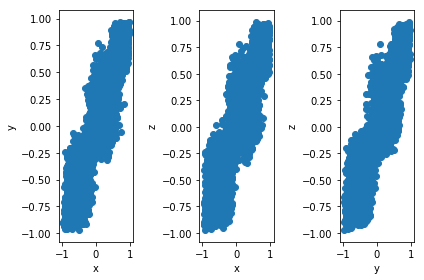

In [91]:
f, (ax1, ax2, ax3) =plt.subplots(1, 3)
ax1.scatter(train[::100, :, 0], train[::100, :, 1])
ax2.scatter(train[::100, :, 0], train[::100, :, 2])
ax3.scatter(train[::100, :, 1], train[::100, :, 2])
ax1.set(xlabel='x', ylabel='y')
ax2.set(xlabel='x', ylabel='z')
ax3.set(xlabel='y', ylabel='z')
f.tight_layout()

In [81]:

test.shape

(25000, 22, 3)

# generator

In [15]:
g = Sequential([
    Dense(22 * 3 * 10, input_dim=100, activation='relu'),
    Reshape((22, 3, 10)),
    Conv2DTranspose(1, (22, 3), activation='tanh', padding='same')
])



g.compile(Adam(), loss='binary_crossentropy')
g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 660)               66660     
_________________________________________________________________
reshape_1 (Reshape)          (None, 22, 3, 10)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 22, 3, 1)          661       
Total params: 67,321
Trainable params: 67,321
Non-trainable params: 0
_________________________________________________________________


In [84]:
g.predict_on_batch(make_latent_samples(5, 100)).shape

(5, 22, 3, 1)

# discriminator

In [19]:
d = Sequential([
    
    Conv2D(32, 3, padding='same', strides=2, input_shape=(22, 3, 1)),
    LeakyReLU(),
    Dropout(0.3),
    
    Conv2D(64, 3, padding='same', strides=1),
    LeakyReLU(),
    Dropout(0.3),
    
    
    Conv2D(128, 3, padding='same', strides=1),
    LeakyReLU(),
    Dropout(0.3),
    
    Flatten(),
    Dense(1, activation='sigmoid')
    
], name='disc')
d.compile(Adam(), 'binary_crossentropy')
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 11, 2, 32)         320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 11, 2, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 2, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 2, 64)         18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 11, 2, 64)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 11, 2, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 2, 128)        73856     
__________

In [20]:
gan = Sequential([g, d])
gan.compile(Adam(), 'binary_crossentropy')

In [21]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 22, 3, 1)          67321     
_________________________________________________________________
disc (Sequential)            (None, 1)                 95489     
Total params: 162,810
Trainable params: 162,810
Non-trainable params: 0
_________________________________________________________________


# Train Loop

In [24]:
batch_size = 500
half_batch = int(batch_size / 2)
num_epochs = 50
eval_size = 100
losses = []


for epoch in range(num_epochs):
    for i in range(len(train)//batch_size):
        # Train Discriminator
        make_trainable(d, True)
        confs = train[i*batch_size:(i+1)*batch_size]
    
        confs = confs.reshape(-1, 22, 3, 1)
    
        # Sample 100 dimensional noise and generate fake confs
        noise = make_latent_samples(batch_size, 100)
        fake_confs = g.predict_on_batch(noise)
    
        # Label smoothing
        # if you have two target labels: Real=1 and Fake=0,
        # then for each incoming sample, if it is real,
        # then replace the label with a random number between 0.7 and 1.2,
        # and if it is a fake sample, replace it with 0.0 and 0.3 (for example).

        label_real = (1.2 - 0.7) * np.random.random(size=(batch_size, 1))  + 0.7
        label_fake = 0.3 * np.random.random(size=(batch_size, 1))
        d.train_on_batch(confs, label_real) 
        d.train_on_batch(fake_confs, label_fake)    
    
        # ---------------------
        #  Train Generator via GAN
        # ---------------------
        noise = make_latent_samples(batch_size, 100)  # generate new noise
        # Train the generator (wants discriminator to mistake images as real)
        make_trainable(d, False)
        labels_real = (1.2 - 0.7) * np.random.random(size=(batch_size, 1))  + 0.7
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
        
    # Evaluate after epoch
    conf_eval_real = test[np.random.choice(len(test), eval_size, replace=False)]
    conf_eval_real = conf_eval_real.reshape(-1, 22, 3, 1)
    noise = make_latent_samples(eval_size, 100)
    conf_eval_fake = g.predict_on_batch(noise)
    
    d_loss_r = d.test_on_batch(conf_eval_real, np.ones(shape=(eval_size, 1)))
    d_loss_f = d.test_on_batch(conf_eval_fake, np.zeros(shape=(eval_size, 1)))
    d_loss = (d_loss_r + d_loss_f) / 2
    
    g_loss = gan.test_on_batch(noise, np.ones(shape=(eval_size, 1)))  # we want the fake to be realistic!
        
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(epoch+1, num_epochs, d_loss, g_loss))
    
    losses.append((d_loss, g_loss))
    

/Users/je714/miniconda3/envs/dl/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:   1/50 Discriminator Loss: 0.8246 Generator Loss: 0.2519
Epoch:   2/50 Discriminator Loss: 1.0616 Generator Loss: 0.1466
Epoch:   3/50 Discriminator Loss: 0.7818 Generator Loss: 0.2904
Epoch:   4/50 Discriminator Loss: 0.9697 Generator Loss: 0.1815
Epoch:   5/50 Discriminator Loss: 0.8231 Generator Loss: 0.2406
Epoch:   6/50 Discriminator Loss: 0.8154 Generator Loss: 0.2535
Epoch:   7/50 Discriminator Loss: 0.8832 Generator Loss: 0.2273
Epoch:   8/50 Discriminator Loss: 0.9397 Generator Loss: 0.1984
Epoch:   9/50 Discriminator Loss: 1.0147 Generator Loss: 0.1758
Epoch:  10/50 Discriminator Loss: 0.9687 Generator Loss: 0.1995
Epoch:  11/50 Discriminator Loss: 0.8026 Generator Loss: 0.3106
Epoch:  12/50 Discriminator Loss: 1.0260 Generator Loss: 0.1674
Epoch:  13/50 Discriminator Loss: 1.0526 Generator Loss: 0.1528
Epoch:  14/50 Discriminator Loss: 0.8723 Generator Loss: 0.2477
Epoch:  15/50 Discriminator Loss: 0.8279 Generator Loss: 0.2838
Epoch:  16/50 Discriminator Loss: 0.8259

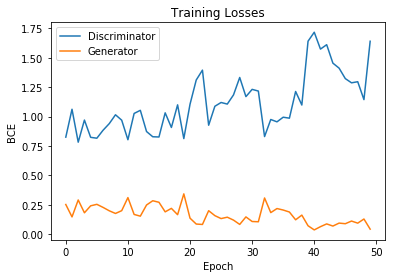

In [61]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
ax.set(ylabel='BCE', xlabel='Epoch')
plt.show()


In [26]:
f0 = g.predict(make_latent_samples(100, 100))

In [27]:

f0[:,:,:,0].shape

(100, 22, 3)

In [28]:
import mdtraj

In [29]:
ala_top = trjs[0].topology

In [47]:
fk_tr = f0[:,:,:,0]

In [56]:
fake_traj_orig_space = [sc.inverse_transform(t) for t in fk_tr]

In [30]:
ala_top

<mdtraj.Topology with 1 chains, 3 residues, 22 atoms, 21 bonds at 0x124406f98>

In [58]:
fake_traj = mdtraj.Trajectory(fake_traj_orig_space, topology=ala_top)
c = fake_traj.center_coordinates()
c.superpose(c, 0)

<mdtraj.Trajectory with 100 frames, 22 atoms, 3 residues, without unitcells at 0x12e069dd8>

In [60]:
c.save_netcdf('fake_traj.nc')

In [ ]:

f0[0].shape

In [ ]:
ax = scatter(test[0])
scatter(f0[0,:,:,0], ax=ax)

In [ ]:
f0[0].shape

In [63]:
real_traj = trjs[0]

In [64]:
real_traj.center_coordinates()
real_traj.superpose(real_traj, 0)
real_traj.save_netcdf('real_traj.nc')

In [76]:
for i, t in enumerate(trjs):
    t.superpose(frame00)
    t.save_netcdf('traj_real{0:02d}.nc'.format(i))
    

In [75]:
frame00

<mdtraj.Trajectory with 1 frames, 22 atoms, 3 residues, without unitcells at 0x124403780>